### Evaluate options for graph embeddings

some useful references:

- https://distill.pub/2021/gnn-intro/
- https://web.stanford.edu/class/cs224w/
- https://pytorch-geometric.readthedocs.io/en/latest/

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
import networkx as nx
import numpy as np
from enum import Enum

import pickle
import networkx as nx
from torch_geometric.nn import GINEConv, global_mean_pool, global_max_pool, global_add_pool

import torch
import torch.nn.functional as F
import os
import glob
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader
import glob
import pickle
from tqdm import tqdm

In [2]:

# Define mappings for one-hot encodings
ACTOR_TYPE_MAPPING = {
    'VEHICLE': 0,
    'PEDESTRIAN': 1,
    'CYCLIST': 2,
    'MOTORCYCLE': 3,
    # Add more types as needed
}

EDGE_TYPE_MAPPING = {
    'neighbor_vehicle': 0,
    'opposite_vehicle': 1,
    'same_lane': 2,
    'adjacent_lane': 3,
    'following': 4,
    'intersection': 5,
    # Add more edge types as needed
}

In [3]:
# Helper function to get feature dimensions
def get_feature_dimensions(actor_type_mapping=None, edge_type_mapping=None):
    """Get the dimensions of node and edge features"""
    if actor_type_mapping is None:
        actor_type_mapping = ACTOR_TYPE_MAPPING
    if edge_type_mapping is None:
        edge_type_mapping = EDGE_TYPE_MAPPING
    
    # Node features: 1 (lon_speed) + num_actor_types (one-hot)
    node_features = 1 + len(actor_type_mapping)
    
    # Edge features: 1 (path_length) + num_edge_types (one-hot)
    edge_features = 1 + len(edge_type_mapping)
    
    return node_features, edge_features

In [4]:

def networkx_to_pyg(nx_graph, actor_type_mapping=None, edge_type_mapping=None):
    """
    Convert NetworkX graph to PyTorch Geometric Data object.
    
    Args:
        nx_graph: NetworkX graph with node and edge attributes
        actor_type_mapping: Dict mapping actor types to indices
        edge_type_mapping: Dict mapping edge types to indices
    
    Returns:
        PyTorch Geometric Data object
    """
    
    # Use default mappings if none provided
    if actor_type_mapping is None:
        actor_type_mapping = ACTOR_TYPE_MAPPING
    if edge_type_mapping is None:
        edge_type_mapping = EDGE_TYPE_MAPPING
    
    # Get node mapping (NetworkX nodes might not be sequential integers)
    nodes = list(nx_graph.nodes())
    node_mapping = {node: idx for idx, node in enumerate(nodes)}
    num_nodes = len(nodes)
    
    # Extract node features
    node_features = []
    for node in nodes:
        node_data = nx_graph.nodes[node]
        
        # Extract lon_speed (continuous feature)
        lon_speed = node_data.get('lon_speed', 0.0)
        
        # Extract actor_type and convert to one-hot
        actor_type = node_data.get('actor_type')
        if hasattr(actor_type, 'value'):  # Handle enum
            actor_type_str = actor_type.value
        else:
            actor_type_str = str(actor_type)
        
        # Get actor type index
        actor_type_idx = actor_type_mapping.get(actor_type_str, 0)  # Default to 0 if unknown
        
        # Create one-hot encoding for actor type
        num_actor_types = len(actor_type_mapping)
        actor_onehot = [0.0] * num_actor_types
        actor_onehot[actor_type_idx] = 1.0
        
        # Combine features: [lon_speed, actor_type_onehot...]
        node_feature = [lon_speed] + actor_onehot
        node_features.append(node_feature)
    
    # Convert to tensor
    x = torch.tensor(node_features, dtype=torch.float)
    
    # Extract edges and edge features
    edge_index = []
    edge_features = []
    
    for source, target, edge_data in nx_graph.edges(data=True):
        # Map node IDs to indices
        source_idx = node_mapping[source]
        target_idx = node_mapping[target]
        
        edge_index.append([source_idx, target_idx])
        
        # Extract path_length (continuous feature)
        path_length = edge_data.get('path_length', 0.0)
        
        # Extract edge_type and convert to one-hot
        edge_type = edge_data.get('edge_type', 'unknown')
        edge_type_idx = edge_type_mapping.get(edge_type, 0)  # Default to 0 if unknown
        
        # Create one-hot encoding for edge type
        num_edge_types = len(edge_type_mapping)
        edge_onehot = [0.0] * num_edge_types
        edge_onehot[edge_type_idx] = 1.0
        
        # Combine features: [path_length, edge_type_onehot...]
        edge_feature = [path_length] + edge_onehot
        edge_features.append(edge_feature)
    
    # Convert to tensors
    if len(edge_index) > 0:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_features, dtype=torch.float)
    else:
        # Handle graphs with no edges
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, 1 + len(edge_type_mapping)), dtype=torch.float)
    
    # Create PyG Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    
    return data



In [5]:


# Enhanced model with training capabilities
class TrainableGraphGINE(torch.nn.Module):
    def __init__(self, node_features, edge_features, embedding_dim=128, hidden_dim=64, num_layers=3, num_classes=None):
        """
        GINE model for graph-level embeddings with optional classification
        
        Args:
            node_features: Number of node features
            edge_features: Number of edge features  
            embedding_dim: Final embedding dimension
            hidden_dim: Hidden layer dimension
            num_layers: Number of GINE layers
            num_classes: Number of classes for supervised learning (None for unsupervised)
        """
        super().__init__()
        
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        
        # GINE layers
        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        
        # First layer
        self.convs.append(
            GINEConv(
                torch.nn.Sequential(
                    torch.nn.Linear(node_features, hidden_dim),
                    torch.nn.BatchNorm1d(hidden_dim),
                    torch.nn.ReLU(),
                    torch.nn.Linear(hidden_dim, hidden_dim)
                ),
                edge_dim=edge_features
            )
        )
        self.batch_norms.append(torch.nn.BatchNorm1d(hidden_dim))
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.convs.append(
                GINEConv(
                    torch.nn.Sequential(
                        torch.nn.Linear(hidden_dim, hidden_dim),
                        torch.nn.BatchNorm1d(hidden_dim),
                        torch.nn.ReLU(),
                        torch.nn.Linear(hidden_dim, hidden_dim)
                    ),
                    edge_dim=edge_features
                )
            )
            self.batch_norms.append(torch.nn.BatchNorm1d(hidden_dim))
        
        # Graph-level pooling and embedding projection
        self.embedding_proj = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim * 3, embedding_dim),  # *3 for mean+max+sum pooling
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(embedding_dim, embedding_dim)
        )
        
        # Projection head for contrastive learning (unsupervised)
        self.projection_head = torch.nn.Sequential(
            torch.nn.Linear(embedding_dim, embedding_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(embedding_dim, embedding_dim // 2)
        )
        
        # Classification head (supervised)
        if num_classes is not None:
            self.classifier = torch.nn.Sequential(
                torch.nn.Dropout(0.3),
                torch.nn.Linear(embedding_dim, num_classes)
            )
        
    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        # Handle empty edge attributes
        if edge_attr.size(0) == 0:
            edge_attr = None
        
        # GINE layers
        for i, (conv, bn) in enumerate(zip(self.convs, self.batch_norms)):
            x = conv(x, edge_index, edge_attr)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=0.2, training=self.training)
        
        # Graph-level pooling
        mean_pool = global_mean_pool(x, batch)
        max_pool = global_max_pool(x, batch)
        sum_pool = global_add_pool(x, batch)
        
        # Concatenate pooling strategies
        graph_repr = torch.cat([mean_pool, max_pool, sum_pool], dim=1)
        
        # Final embedding
        embeddings = self.embedding_proj(graph_repr)
        
        outputs = {'embeddings': embeddings}
        
        # Add projection for contrastive learning
        outputs['projection'] = self.projection_head(embeddings)
        
        # Add classification if applicable
        if hasattr(self, 'classifier'):
            outputs['logits'] = self.classifier(embeddings)
        
        return outputs
    
    def get_embedding(self, data):
        """Extract embeddings only"""
        self.eval()
        with torch.no_grad():
            outputs = self.forward(data)
            return outputs['embeddings']


In [6]:
# Contrastive loss
def contrastive_loss(z1, z2, temperature=0.1):
    """InfoNCE contrastive loss"""
    batch_size = z1.size(0)
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    
    # Compute similarity matrix
    sim_matrix = torch.mm(z1, z2.t()) / temperature
    
    # Labels for positive pairs (diagonal)
    labels = torch.arange(batch_size, device=z1.device)
    
    return F.cross_entropy(sim_matrix, labels)

# Data augmentation for contrastive learning
def augment_graph(data):
    """Simple graph augmentation"""
    augmented_data = data.clone()
    
    # Add noise to continuous features
    # Node features: first feature is lon_speed
    if augmented_data.x.size(1) > 0:
        augmented_data.x[:, 0] += torch.randn_like(augmented_data.x[:, 0]) * 0.1
    
    # Edge features: first feature is path_length
    if augmented_data.edge_attr.size(0) > 0 and augmented_data.edge_attr.size(1) > 0:
        augmented_data.edge_attr[:, 0] += torch.randn_like(augmented_data.edge_attr[:, 0]) * 0.1
    
    return augmented_data



In [7]:
# Model setup
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
node_dim, edge_dim = get_feature_dimensions()
model = TrainableGraphGINE(node_dim, edge_dim, 256, 96, 4).to(device)

# Training
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [8]:
from torch.utils.data import Dataset

class GraphDataset(Dataset):
    def __init__(self, graph_paths):
        self.graph_paths = graph_paths
        
    def __len__(self):
        return len(self.graph_paths)
    
    def __getitem__(self, idx):
        file_path = self.graph_paths[idx]
        with open(file_path, 'rb') as f:
            nx_graph = pickle.load(f)
        pyg_data = networkx_to_pyg(nx_graph)
        return pyg_data, file_path


In [9]:
# Load data
graph_paths = glob.glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/*.pkl")
dataset = []

# for path in graph_paths:
#    with open(path, 'rb') as f:
#        nx_graph = pickle.load(f)
#    pyg_data = networkx_to_pyg(nx_graph)
#    dataset.append(pyg_data)

graph_ds = GraphDataset(graph_paths)
# Data loader
#train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(graph_ds, batch_size=32, shuffle=True)

/home/tmuehlen/.cache/pypoetry/virtualenvs/graph-creator-_1ofKhL9-py3.10/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [10]:
set([path.split("/")[-1].split("_")[1] for path in graph_paths])


{'2025-08-23 23:19:38.811319',
 '2025-08-24 13:09:53.255648',
 '2025-08-24 13:26:57.295150',
 '2025-08-24 13:30:03.751131',
 '2025-08-24 13:32:59.428368',
 '2025-08-24 13:39:13.698326',
 '2025-08-24 13:43:23.995928',
 '2025-08-25 22:13:36.453956',
 '2025-08-25 22:15:25.146980',
 '2025-08-25 22:17:26.441626',
 '2025-08-25 22:31:44.757262',
 '2025-08-25 22:32:52.848707',
 '2025-08-27 22:37:11.487023',
 '2025-08-27 22:38:34.861141',
 '2025-08-27 22:42:35.846630',
 '2025-08-30 21:46:28.006975',
 '2025-08-30 21:50:42.400301',
 '2025-08-30 21:54:29.005142',
 '2025-08-30 22:08:30.926841',
 '2025-08-30 22:13:29.870307',
 '2025-08-30 22:16:29.872627',
 '2025-08-30 22:18:25.433697',
 '2025-08-30 22:20:23.195071',
 '2025-08-30 22:22:27.597921',
 '2025-08-30 22:23:13.009936',
 '2025-08-30 22:24:14.699788',
 '2025-08-30 22:25:07.988099',
 '2025-08-30 22:26:09.200293',
 '2025-08-30 22:26:55.620015',
 '2025-08-30 22:28:18.847801'}

In [ ]:
graph_ds.__getitem__(10)
batch = next(iter(train_loader))
# batch[1]

In [12]:
for epoch in range(50):
    total_loss = 0
   
    for batch in train_loader:
        batch = batch[0].to(device)
        aug_batch = augment_graph(batch).to(device)

        optimizer.zero_grad()

        outputs1 = model(batch)
        outputs2 = model(aug_batch)

        loss = contrastive_loss(outputs1['projection'], outputs2['projection'])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # if epoch % 1 == 0:
    print(f'Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}')

# Save model
#torch.save(model.state_dict(), 'gine_model.pth')

Epoch 0, Loss: 0.5883
Epoch 1, Loss: 0.3529
Epoch 2, Loss: 0.3017
Epoch 3, Loss: 0.2550
Epoch 4, Loss: 0.2533
Epoch 5, Loss: 0.2248
Epoch 6, Loss: 0.2192
Epoch 7, Loss: 0.2146
Epoch 8, Loss: 0.1984
Epoch 9, Loss: 0.2139
Epoch 10, Loss: 0.1830
Epoch 11, Loss: 0.1774
Epoch 12, Loss: 0.1657
Epoch 13, Loss: 0.1462
Epoch 14, Loss: 0.1455
Epoch 15, Loss: 0.1527
Epoch 16, Loss: 0.1430
Epoch 17, Loss: 0.1268
Epoch 18, Loss: 0.1213
Epoch 19, Loss: 0.1205
Epoch 20, Loss: 0.1168
Epoch 21, Loss: 0.1146
Epoch 22, Loss: 0.1179
Epoch 23, Loss: 0.1129
Epoch 24, Loss: 0.1133
Epoch 25, Loss: 0.1079
Epoch 26, Loss: 0.1045
Epoch 27, Loss: 0.1040
Epoch 28, Loss: 0.1115
Epoch 29, Loss: 0.1000
Epoch 30, Loss: 0.0965
Epoch 31, Loss: 0.0885
Epoch 32, Loss: 0.0908
Epoch 33, Loss: 0.1040
Epoch 34, Loss: 0.0912
Epoch 35, Loss: 0.0915
Epoch 36, Loss: 0.0898
Epoch 37, Loss: 0.0847
Epoch 38, Loss: 0.0845
Epoch 39, Loss: 0.0919
Epoch 40, Loss: 0.0860
Epoch 41, Loss: 0.0852
Epoch 42, Loss: 0.0836
Epoch 43, Loss: 0.090

In [15]:
# Inference loop
model.eval()
all_embeddings = []
all_paths = []

with torch.no_grad():
   for batch in tqdm(train_loader):  # or test_loader
       all_paths.extend(batch[1]) 
       batch = batch[0].to(device)
       outputs = model(batch)
       embeddings = outputs['embeddings']
       all_embeddings.append(embeddings.cpu())

# Concatenate all embeddings
final_embeddings = torch.cat(all_embeddings, dim=0)
print(f'Extracted {final_embeddings.shape[0]} embeddings of dimension {final_embeddings.shape[1]}')

100%|██████████| 222/222 [00:03<00:00, 68.92it/s]

Extracted 7074 embeddings of dimension 256


In [25]:
graph_dates = [path.split("/")[-1].split("_")[1] for path in all_paths]
all_paths


['/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_2025-08-23 23:19:38.811319_14_8.pkl',
 '/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_2025-08-30 21:50:42.400301_0_11.pkl',
 '/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_2025-08-23 23:19:38.811319_62_6.pkl',
 '/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_2025-08-30 22:13:29.870307_10_12.pkl',
 '/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_2025-08-23 23:19:38.811319_13_14.pkl',
 '/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_2025-08-30 22:16:29.872627_9_2.pkl',
 '/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_2025-08-27 22:38:34.861141_8_20.pkl',
 '/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_2025-08-23 23:19:38.811319_68_9.pkl',
 '/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_2025-08-24 13:32:59.428368_11_8.pkl',
 '/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_2025-08-23 23:19:38.811319_

,0,1,timestamp,graph_path
0,-108.461670,-14.324265,2025-08-23 23:19:38.811319,/home/tmuehlen/repos/graph_coverage/actor_grap...
1,-5.072052,88.138077,2025-08-30 21:50:42.400301,/home/tmuehlen/repos/graph_coverage/actor_grap...
2,-48.395065,31.932381,2025-08-23 23:19:38.811319,/home/tmuehlen/repos/graph_coverage/actor_grap...
3,-157.040726,-90.737076,2025-08-30 22:13:29.870307,/home/tmuehlen/repos/graph_coverage/actor_grap...
4,344.679016,402.348022,2025-08-23 23:19:38.811319,/home/tmuehlen/repos/graph_coverage/actor_grap...


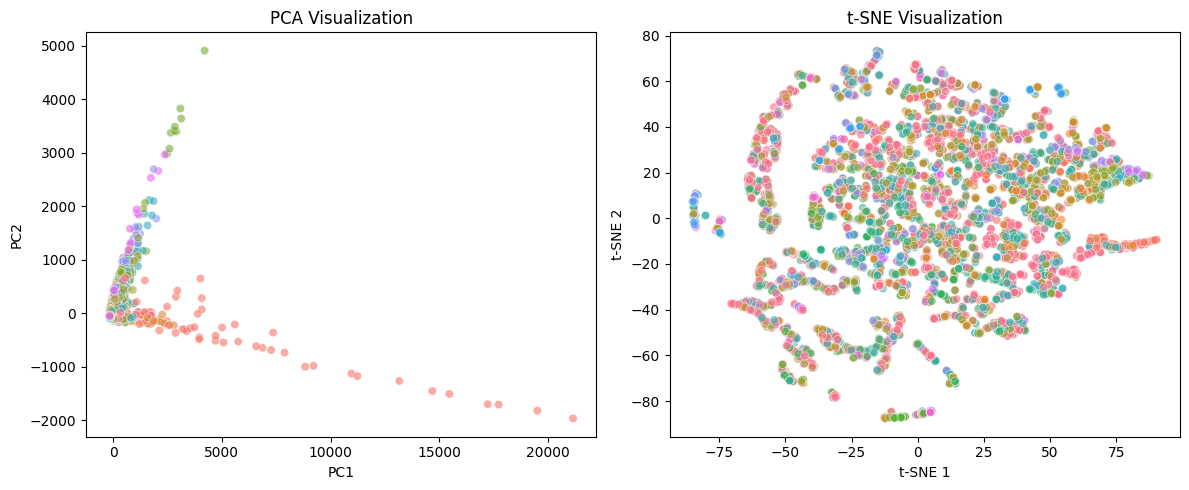

In [29]:
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

# Convert embeddings to numpy
embeddings_np = final_embeddings.numpy()

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_np)

pca_df = pd.DataFrame(pca_result)
pca_df.columns = ["pca1", "pca2"]
pca_df["timestamp"] = graph_dates
pca_df["graph_path"] = all_paths
pca_df.head()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x="pca1", y="pca2", alpha=0.6, hue="timestamp", legend = False, data=pca_df)
#plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
plt.title('PCA Visualization')
plt.xlabel('PC1')
plt.ylabel('PC2')

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(embeddings_np)
tsne_df = pd.DataFrame(tsne_result)
tsne_df.columns = ["tsne1", "tsne2"]
tsne_df["timestamp"] = graph_dates
tsne_df["graph_path"] = all_paths

plt.subplot(1, 2, 2)
# plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.6)
sns.scatterplot(x="tsne1", y="tsne2", alpha=0.6, hue="timestamp", legend = False, data=tsne_df)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

In [36]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Convert embeddings to numpy
embeddings_np = final_embeddings.numpy()

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_np)

pca_df = pd.DataFrame(pca_result)
pca_df.columns = ["pca1", "pca2"]
pca_df["timestamp"] = graph_dates
pca_df["graph_path"] = all_paths

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(embeddings_np)
tsne_df = pd.DataFrame(tsne_result)
tsne_df.columns = ["tsne1", "tsne2"]
tsne_df["timestamp"] = graph_dates
tsne_df["graph_path"] = all_paths

# Create subplots
fig = make_subplots(
   rows=1, cols=2,
   subplot_titles=('PCA Visualization', 't-SNE Visualization'),
   horizontal_spacing=0.1
)

# PCA scatter plot
fig.add_trace(
   go.Scatter(
       x=pca_df['pca1'],
       y=pca_df['pca2'],
       mode='markers',
       marker=dict(
           size=6,
           color=pca_df.index,  # Color by index or use timestamp
           colorscale='viridis',
           opacity=0.7
       ),
       text=[f"Path: {path}<br>Timestamp: {ts}" for path, ts in zip(pca_df['graph_path'], pca_df['timestamp'])],
       hovertemplate='<b>PCA Point</b><br>' +
                    'PC1: %{x:.3f}<br>' +
                    'PC2: %{y:.3f}<br>' +
                    '%{text}<extra></extra>',
       name='PCA'
   ),
   row=1, col=1
)

# t-SNE scatter plot
fig.add_trace(
   go.Scatter(
       x=tsne_df['tsne1'],
       y=tsne_df['tsne2'],
       mode='markers',
       marker=dict(
           size=6,
           color=tsne_df.index,  # Color by index or use timestamp
           colorscale='viridis',
           opacity=0.7
       ),
       text=[f"Path: {path}<br>Timestamp: {ts}" for path, ts in zip(tsne_df['graph_path'], tsne_df['timestamp'])],
       hovertemplate='<b>t-SNE Point</b><br>' +
                    't-SNE1: %{x:.3f}<br>' +
                    't-SNE2: %{y:.3f}<br>' +
                    '%{text}<extra></extra>',
       name='t-SNE'
   ),
   row=1, col=2
)

# Update layout
fig.update_layout(
   title_text="Interactive Embedding Visualization",
   showlegend=False,
   height=500,
   width=1200
)

# Update x and y axis labels
fig.update_xaxes(title_text="PC1", row=1, col=1)
fig.update_yaxes(title_text="PC2", row=1, col=1)
fig.update_xaxes(title_text="t-SNE 1", row=1, col=2)
fig.update_yaxes(title_text="t-SNE 2", row=1, col=2)

# Show interactive plot
fig.show()


In [37]:
"2025-08-24 13:26:57.295150_4_0"
"2025-08-25 22:17:26.441626_5_3"

'2025-08-25 22:17:26.441626_5_3'

In [21]:
from graph_creator.plot_graphs import plot_lane_map_advanced, add_actors_to_map, add_actor_edges_to_map

In [ ]:
# next ToDO: update with the graphs from above
# fig, ax = plot_lane_map_advanced(g_map.graph, color_by_length=True, cmap='plasma', show_labels=False)
# fig, ax = add_actors_to_map(fig, ax, ag_carla.actor_graphs[ag_timestamps[0]], actor_size=20, show_actor_labels=False)
# fig, ax = add_actor_edges_to_map(fig, ax, ag_carla.actor_graphs[ag_timestamps[0]])
# plt.show()


# Notebook junkyard